
# 🌱 ESG Stock Event Study — **Market Model** (Demo)

This notebook implements an event study using the **market model**:

\[ R_{i,t} = \alpha_i + \beta_i R_{m,t} + \epsilon_{i,t} \]

- **Estimation window:** τ ∈ [-120, -20] (fit α, β per event)
- **Event window:** τ ∈ [-5, +5]
- **AR:** abnormal return = actual − expected (α + β·R_m)
- **AAR / CAR:** averaged and cumulative abnormal returns across events

> It reads the daily-updated CSVs generated by your pipeline in `data/latest/`.


In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Data loading helpers ---
def load_returns(path: str) -> pd.DataFrame:
    """Load returns CSV with dates as index."""
    return pd.read_csv(path, parse_dates=[0], index_col=0)

def load_events(path: str) -> pd.DataFrame:
    """
    Load ESG events file and standardize to ['ticker', 'event_date'].
    Supports multiple date column names, including 'published_utc'.
    Returns an empty DataFrame if file missing or invalid.
    """
    if (not os.path.exists(path)) or os.path.getsize(path) == 0:
        return pd.DataFrame(columns=["ticker", "event_date"])

    header_row = pd.read_csv(path, nrows=0)
    cols = list(header_row.columns)
    has_header = len(cols) > 0 and not all(str(c).startswith("Unnamed") for c in cols)

    date_aliases = {
        "event_date", "date", "eventdate", "event_dt",
        "announcement_date", "published_utc"
    }

    if has_header:
        df = pd.read_csv(path)
        df.columns = [str(c).strip() for c in df.columns]
        lower_map = {c.lower(): c for c in df.columns}

        # Identify date column
        event_date_col = next((lower_map[a] for a in date_aliases if a in lower_map), None)
        # Identify ticker column
        ticker_col = next((c for c in df.columns if c.lower() in {"ticker", "symbol"}), None)

        # Fallback: guess when only two columns exist
        if event_date_col is None and df.shape[1] == 2:
            for c in df.columns:
                try:
                    pd.to_datetime(df[c], errors="raise"); event_date_col = c; break
                except Exception:
                    pass
            if ticker_col is None:
                ticker_col = [c for c in df.columns if c != event_date_col][0] if event_date_col else df.columns[0]

        if event_date_col is None:
            print("Warning: could not detect a date column in", path)
            return pd.DataFrame(columns=["ticker", "event_date"])

        # Parse and normalize dates
        ev_dt = pd.to_datetime(df[event_date_col], errors="coerce", utc=True)
        ev_dt = ev_dt.dt.tz_convert(None).dt.normalize()

        out = pd.DataFrame({
            "ticker": df[ticker_col].astype(str) if ticker_col else np.nan,
            "event_date": ev_dt
        }).dropna(subset=["event_date"]).reset_index(drop=True)
        return out

    else:
        df = pd.read_csv(path, header=None, names=["ticker", "event_date"])
        df["event_date"] = pd.to_datetime(df["event_date"], errors="coerce").dt.normalize()
        return df.dropna(subset=["event_date"]).reset_index(drop=True)

# --- File paths ---
CANDIDATES = [
    "data/latest",
    "data-science-projects-starter/data-science-projects/esg-stock-event-study/data/latest"
]
DATA_LATEST = next((p for p in CANDIDATES if os.path.exists(p)), None)
if DATA_LATEST is None:
    raise FileNotFoundError("Could not find data/latest. Run the pipeline first.")

prices_path  = os.path.join(DATA_LATEST, "prices_latest.csv")
returns_path = os.path.join(DATA_LATEST, "returns_latest.csv")
events_path  = os.path.join(DATA_LATEST, "esg_events_latest.csv")

# --- Load data ---
rets   = load_returns(returns_path)
events = load_events(events_path)

print("Returns shape:", rets.shape)
print("Events shape:", events.shape)
print(events.head())



Returns shape: (520, 5)
Events shape: (749, 2)
  ticker event_date
0   AAPL 2025-09-30
1   AAPL 2025-09-27
2   AAPL 2025-09-27
3   AAPL 2025-09-27
4   AAPL 2025-09-27



## 1) Choose market return series
Tries common tickers in order: `^GSPC`, `SPY`, `VOO`, `IVV`.  
Falls back to **equal-weighted average** of all returns if none found.


In [14]:

MARKET_CANDIDATES = ["^GSPC", "SPY", "VOO", "IVV"]
market_col = next((c for c in MARKET_CANDIDATES if c in rets.columns), None)

if market_col is None:
    # Fallback: equal-weighted average of valid tickers
    valid_cols = [c for c in rets.columns if rets[c].notna().mean() > 0.8]
    market_col = "_EW_MARKET_"
    rets[market_col] = rets[valid_cols].mean(axis=1)

print("Using market series:", market_col)
rets[[market_col]].dropna().tail()


Using market series: _EW_MARKET_


,_EW_MARKET_
Date,
2025-09-24,0.002605
2025-09-25,-0.009335
2025-09-26,0.010789
2025-09-29,0.001853
2025-09-30,-0.000978



## 2) Fit α, β on the estimation window and compute AR in the event window


In [15]:
from datetime import timedelta

EST_WIN = (-120, -20)
EVT_WIN = (-5, 5)

def align_to_trading_day(dates: pd.Series, trading_index: pd.DatetimeIndex, method="next") -> pd.Series:
    """Align event dates to nearest trading day (next or previous)."""
    td = pd.Index(pd.to_datetime(trading_index).normalize().unique()).sort_values()
    normalized = pd.to_datetime(dates).dt.normalize()
    out = []
    for d in normalized:
        idx = td.get_indexer([d], method="backfill" if method=="next" else "ffill")
        if idx[0] == -1:
            out.append(td[0] if method=="next" else td[-1])
        else:
            out.append(td[idx[0]])
    return pd.to_datetime(out)

def fit_alpha_beta(stock: pd.Series, market: pd.Series, event_date: pd.Timestamp):
    """Estimate alpha and beta using OLS over the estimation window."""
    start = event_date + timedelta(days=EST_WIN[0])
    end   = event_date + timedelta(days=EST_WIN[1])
    s = stock.loc[(stock.index >= start) & (stock.index <= end)]
    m = market.loc[(market.index >= start) & (market.index <= end)]
    df = pd.DataFrame({"s": s, "m": m}).dropna()
    if len(df) < 30:
        return np.nan, np.nan
    X = np.vstack([np.ones(len(df)), df["m"].values]).T
    y = df["s"].values
    beta_vec = np.linalg.pinv(X) @ y
    alpha, beta = float(beta_vec[0]), float(beta_vec[1])
    return alpha, beta

def compute_event_ar_table(rets_df: pd.DataFrame, events_df: pd.DataFrame, mkt_col: str) -> pd.DataFrame:
    """Compute abnormal returns for each event and each tau in the event window."""
    rows = []
    r = rets_df.copy()
    r.index = pd.to_datetime(r.index)

    if not events_df.empty:
        events_df = events_df[events_df["ticker"].isin(r.columns)].copy()

    if events_df.empty:
        return pd.DataFrame(columns=["date","ticker","event_date","tau","ret","mkt","exp_ret","ar","alpha","beta"])

    events_df["event_date"] = align_to_trading_day(events_df["event_date"], r.index, method="next")

    for _, ev in events_df.iterrows():
        tic = ev.get("ticker")
        if tic not in r.columns:
            continue
        event_date = pd.to_datetime(ev["event_date"]).normalize()

        alpha, beta = fit_alpha_beta(r[tic], r[mkt_col], event_date)
        if np.isnan(alpha) or np.isnan(beta):
            continue

        start = event_date + timedelta(days=EVT_WIN[0])
        end   = event_date + timedelta(days=EVT_WIN[1])
        seg = r.loc[(r.index >= start) & (r.index <= end), [tic, mkt_col]].copy()
        if seg.empty:
            continue

        seg["date"] = seg.index
        seg["tau"] = (seg["date"].dt.normalize() - event_date).dt.days
        seg["ticker"] = tic
        seg["event_date"] = event_date
        seg.rename(columns={tic: "ret", mkt_col: "mkt"}, inplace=True)

        seg["exp_ret"] = alpha + beta * seg["mkt"]
        seg["ar"] = seg["ret"] - seg["exp_ret"]
        seg["alpha"] = alpha
        seg["beta"] = beta
        rows.append(seg[["date","ticker","event_date","tau","ret","mkt","exp_ret","ar","alpha","beta"]])

    if not rows:
        return pd.DataFrame(columns=["date","ticker","event_date","tau","ret","mkt","exp_ret","ar","alpha","beta"])
    return pd.concat(rows, ignore_index=True)

event_ar = compute_event_ar_table(rets, events, market_col)
display(event_ar.head())
print("Unique tickers in AR table:", event_ar["ticker"].nunique() if not event_ar.empty else 0)
print("Original events count:", events.shape[0])


,date,ticker,event_date,tau,ret,mkt,exp_ret,ar,alpha,beta
0,2025-09-25,AAPL,2025-09-30,-5,0.018073,-0.009335,-0.007237,0.025310,0.000186,0.795213
1,2025-09-26,AAPL,2025-09-30,-4,-0.005489,0.010789,0.008766,-0.014255,0.000186,0.795213
2,2025-09-29,AAPL,2025-09-30,-1,-0.004032,0.001853,0.001659,-0.005691,0.000186,0.795213
3,2025-09-30,AAPL,2025-09-30,0,0.000786,-0.000978,-0.000592,0.001378,0.000186,0.795213
4,2025-09-24,AAPL,2025-09-29,-5,-0.008332,0.002605,0.002576,-0.010908,0.000601,0.758100


Unique tickers in AR table: 5
Original events count: 749



## 3) Aggregate AAR & CAR (and simple t-stats)
For each τ, we compute:
- **AAR(τ)** = mean of AR across events  
- **t(τ)** = AAR(τ) / (sd(AR_τ) / √N) — simple cross-sectional test  
- **CAR(τ)** = cumulative sum of AAR up to τ


In [16]:

def aggregate_aar_car_with_t(event_ar_df: pd.DataFrame):
    """
    Compute average abnormal returns (AAR), cumulative abnormal returns (CAR),
    and t-statistics across events.
    """
    if event_ar_df.empty:
        return pd.DataFrame(columns=["tau","AAR","N","sd","t"]), pd.DataFrame(columns=["tau","CAR"])

    stats = (
        event_ar_df
        .groupby("tau")["ar"]
        .agg(AAR="mean", sd=lambda x: x.std(ddof=1), N="count")
        .reset_index()
        .sort_values("tau")
    )
    denom = stats["sd"] / np.sqrt(stats["N"].where(stats["N"]>0, np.nan))
    stats["t"] = stats["AAR"] / denom.replace(0, np.nan)
    stats.replace([np.inf, -np.inf], np.nan, inplace=True)

    car = stats[["tau","AAR"]].copy()
    car["CAR"] = car["AAR"].cumsum()

    return stats[["tau","AAR","N","sd","t"]], car[["tau","CAR"]]

aar, car = aggregate_aar_car_with_t(event_ar)
display(aar.head())
display(car.head())


,tau,AAR,N,sd,t
0,-5,0.003695,660,0.016719,5.677463
1,-4,-0.004458,702,0.011256,-10.493149
2,-3,0.008306,371,0.011064,14.459865
3,-2,0.022830,93,0.015441,14.258699
4,-1,-0.003730,467,0.016775,-4.804966


,tau,CAR
0,-5,0.003695
1,-4,-0.000763
2,-3,0.007543
3,-2,0.030373
4,-1,0.026643



## 4) Plots


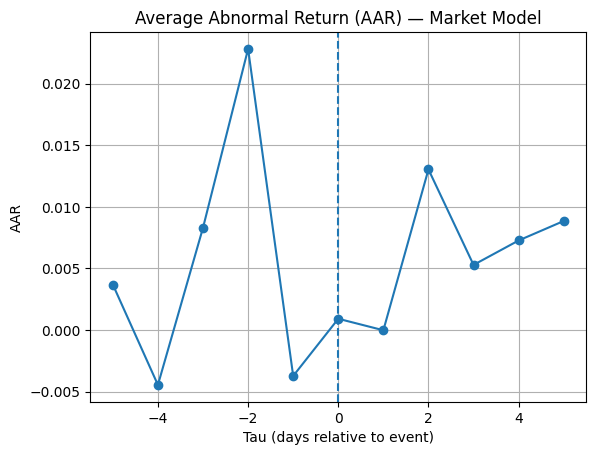

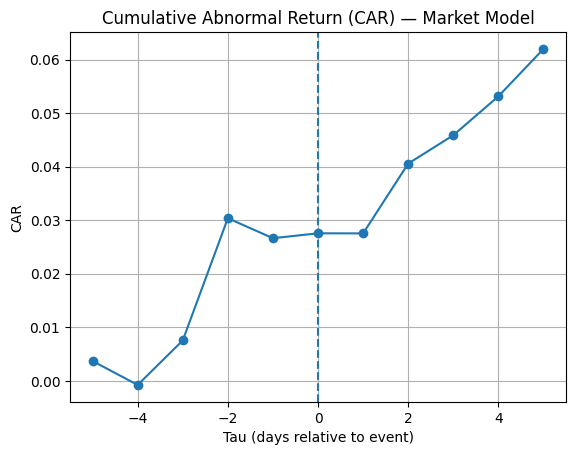

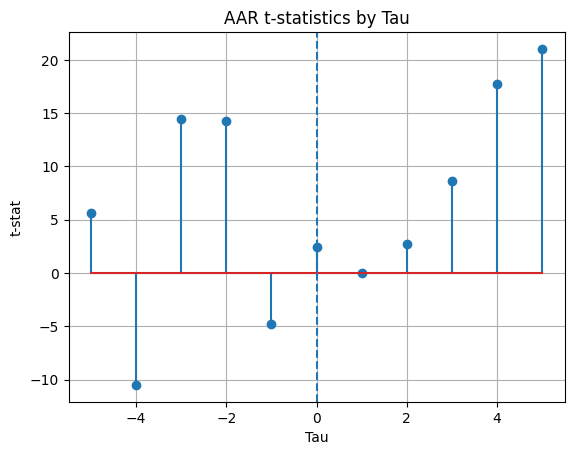

In [17]:
plt.figure()
plt.plot(aar["tau"], aar["AAR"], marker="o")
plt.axvline(0, linestyle="--")
plt.title("Average Abnormal Return (AAR) — Market Model")
plt.xlabel("Tau (days relative to event)")
plt.ylabel("AAR")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(car["tau"], car["CAR"], marker="o")
plt.axvline(0, linestyle="--")
plt.title("Cumulative Abnormal Return (CAR) — Market Model")
plt.xlabel("Tau (days relative to event)")
plt.ylabel("CAR")
plt.grid(True)
plt.show()

plt.figure()
plt.stem(aar["tau"], aar["t"])  # <-- removed use_line_collection
plt.axvline(0, linestyle="--")
plt.title("AAR t-statistics by Tau")
plt.xlabel("Tau")
plt.ylabel("t-stat")
plt.grid(True)
plt.show()




## 5) Inspect one example event window


In [18]:
if not event_ar.empty:
    example = (
        event_ar.sort_values(["event_date","ticker","tau"])
                .groupby(["ticker","event_date"])
                .head(11)
    )
    display(example.head(20))
else:
    print("No event AR table generated. Check ESG events or adjust tickers/keywords.")



,date,ticker,event_date,tau,ret,mkt,exp_ret,ar,alpha,beta
103,2025-09-19,MSFT,2025-09-24,-5,0.018645,0.016910,0.005558,0.013087,0.001135,0.261529
110,2025-09-19,MSFT,2025-09-24,-5,0.018645,0.016910,0.005558,0.013087,0.001135,0.261529
104,2025-09-22,MSFT,2025-09-24,-2,-0.006719,0.006050,0.002718,-0.009437,0.001135,0.261529
111,2025-09-22,MSFT,2025-09-24,-2,-0.006719,0.006050,0.002718,-0.009437,0.001135,0.261529
105,2025-09-23,MSFT,2025-09-24,-1,-0.010147,-0.013938,-0.002510,-0.007637,0.001135,0.261529
112,2025-09-23,MSFT,2025-09-24,-1,-0.010147,-0.013938,-0.002510,-0.007637,0.001135,0.261529
106,2025-09-24,MSFT,2025-09-24,0,0.001807,0.002605,0.001817,-0.000010,0.001135,0.261529
113,2025-09-24,MSFT,2025-09-24,0,0.001807,0.002605,0.001817,-0.000010,0.001135,0.261529
107,2025-09-25,MSFT,2025-09-24,1,-0.006116,-0.009335,-0.001306,-0.004810,0.001135,0.261529
114,2025-09-25,MSFT,2025-09-24,1,-0.006116,-0.009335,-0.001306,-0.004810,0.001135,0.261529
